<a href="https://colab.research.google.com/github/GuilhermeSebin/DIO_Santander_Bootcamp2/blob/main/Rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [43]:
transform = transforms.ToTensor() #definindo a conversão de imagem para Tensor
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # cria um buffer para pegar os dados por partes

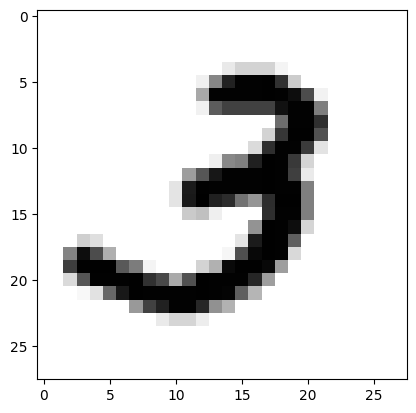

In [44]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [45]:
print(imagens[0].shape) # verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # verificar a dimensão do tensor da cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [46]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28,128) #camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10

    def forward(self, X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

In [47]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = time()

  criterio = nn.NLLLoss()
  EPOCHS = 10
  modelo.train()

  for epoch in range(EPOCHS):
    perda_acumulada = 0

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1)
      otimizador.zero_grad()

      output = modelo(imagens.to(device))
      perda_instantanea = criterio(output, etiquetas.to(device))

      perda_instantanea.backward()
      otimizador.step()

      perda_acumulada += perda_instantanea.item()
    else:
      print("Epochs {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (min) =", (time()-inicio)/60)

In [48]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      with torch.no_grad():
        logps = modelo(img.to(device))

      ps = torch.exp(logps)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1

  print("total de imagens testadas =", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


In [49]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)